# Exercise 3

Perform a perturbation series expansion on the equation for the damped harmonic oscillator

\begin{equation}
    \frac{\text{d}^2 x(t)}{\text{d} t^2} + 2\epsilon 
        \frac{\text{d} x(t)}{\text{d} t} + x(t) = 0\ .
\end{equation}

Solve the equations of motion, up to first order

\begin{equation}
    x(t) = x_0(t) + \epsilon x_1(t) + \mathcal{O}(\epsilon^2)
\end{equation}

Find the exact solution too. Plot the results for the exact solution and its 0th and 1st order approximation.

### Import sympy and define symbols

In [1]:
from sympy import *
init_printing()  # import the best printer available
eps, t = symbols('epsilon t', positive=True)
x, x0, x1 = symbols('x x_0 x_1', cls=Function)

Note that many of the steps above are unnecessary to reach the final solution. I include them for pedagogical purposes. In this kind of problems, I encourage you to encapsulate the steps in functions (for instance, you could create a function that splits the differential equation up to any desired order and try to solve the hierarchy). Here I am trying to keep it as simple as possible.

### Define the differential equation

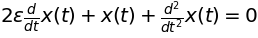

In [2]:
equation = Eq(Derivative(x(t), t, 2) + 2*eps*Derivative(x(t), t) + x(t), 0)
equation

### Expand the equation of motion 

First, I define the perturbative expansion

In [3]:
pert = {x(t): x0(t) + eps*x1(t) + Order(eps**2)}
pert

Now I expand the equation (had the dependency on $\epsilon$ not been linear, I would have needed to use the `series()` method)

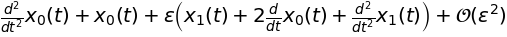

In [4]:
lhs = equation.lhs
lhs = lhs.subs(pert).doit()   # derivate
lhs = lhs.expand()            # expand the parenthesis
lhs = lhs.collect(eps)        # take equal powers of epsilon

lhs

Define the system of equations for the hierarchy of perturbations

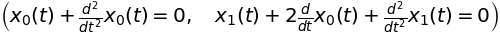

In [5]:
eq0 = Eq(lhs.coeff(eps, n=0), 0)
eq1 = Eq(lhs.coeff(eps, n=1), 0)

eq0, eq1

### Find the solution for the zeroth-order

We need to compute the zero order solution and then insert it in the first order equation

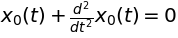

In [6]:
eq0

Define symbols for the initial conditions

In [7]:
x_ini, dx_ini = symbols('X_i \dot{X}_i')

In this case, the equation is pretty easy to solve

In [8]:
initial_conditions = {x0(0):x_ini,\
                      diff(x0(t), t).subs(t, 0):dx_ini}

sol0 = dsolve(eq0, ics=initial_conditions)
sol0

I create a substitution rule to insert this solution in the first order equation

In [9]:
rule0 = {sol0.lhs: sol0.rhs}
rule0

### Find the solution for the first-order

The same for the next order, substituting $x_0(t)$,

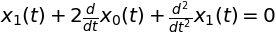

In [10]:
eq1

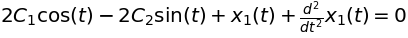

In [11]:
new_eq1 = eq1.subs(rule0).doit().simplify()
new_eq1

Now to find the initial conditions for $x_1$ we impose that

\begin{equation}
    x(0) = x_0(0)\ ,\qquad \dot{x}(0)=\dot{x_0}(0)\ ,
\end{equation}

so that

\begin{equation}
    x_1(0) = \dot{x_1}(0) = 0
\end{equation}

In [12]:
initial_conditions = {x1(0):0,\
                      diff(x1(t), t).subs(t, 0):0}

sol1 = dsolve(new_eq1, x1(t), ics=initial_conditions)
sol1

### Find the exact solution and expand it

The exact solution can be analitically found in this case

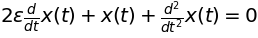

In [13]:
equation

In [14]:
initial_conditions = {x(0):x_ini,\
                      diff(x(t), t).subs(t, 0):dx_ini}

sol_exact = dsolve(equation, ics=initial_conditions)
sol_exact

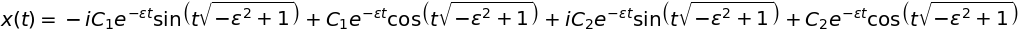

In [15]:
expr = sol_exact.rhs.expand().collect(exp(-eps*t))
expr = use(expr, lambda f: f.rewrite(sin), level=2)
expr = use(expr, expand, level=2)
expr = use(expr, simplify, level=3)
expr = expr.subs(sqrt(eps**2-1), I*sqrt(1-eps**2))

for var in expr.atoms(sin, cos):
    expr = collect(expr, var)

expr = use(expr, simplify, level=2)
expr = expr.expand(deep=0)

sol_exact_simp = Eq(x(t), expr)
sol_exact_simp

Finally, we can expand our exact solution to first order

In [16]:
exact_expanded = Eq(sol_exact_simp.lhs, \
                    sol_exact_simp.rhs.series(eps, 0, 2))
exact_expanded

### Plot the results and compare the exact-0th-1st solutions

Now I am going to compare the exact solution and the result of the perturbative expansion.

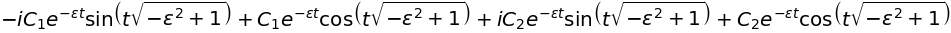

In [17]:
exact = sol_exact_simp.rhs
exact

In [18]:
zeroth = sol0.rhs
zeroth

In [19]:
first = sol1.rhs
first

I create the numerical functions to compare the results

In [20]:
num_exact = lambdify([t, x_ini, dx_ini, eps], exact, "numpy")
num_zeroth = lambdify([t, x_ini, dx_ini, eps], zeroth, "numpy")
num_first = lambdify([t, x_ini, dx_ini, eps], first, "numpy")

Then I evaluate them with `numpy` and plot the results with `matplotlib`. Check the little trick with numpy below.

In [21]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# I am adding an 'n' before just not to redefine the symbolic variables.
# It does not matter if I am not going to use them anymore.
neps = 0.1
nx0 = 0.
ndx0 = 1
nt = np.linspace(0, 50, 1000)

# here I add +0J (zero imaginary unit for numpy) to force numpy to use
# the functions appropiate for complex numbers. Of course, our solution
# is real but the symbolic form we have plugged in looks complex for some
# values of the parameters (eps < 1)
nexact = num_exact(nt, nx0, ndx0, neps+0J)
nzeroth = num_zeroth(nt, nx0, ndx0, neps)
nfirst = nzeroth + neps*num_first(nt, nx0, ndx0, neps)

In [22]:
plt.figure(1)
plt.plot(nt, nexact.real, label="Exact")
plt.plot(nt, nfirst, label="First order")
plt.legend(loc="best");

<IPython.core.display.Javascript object>

SystemError: <built-in function hasattr> returned a result with an error set

We can see that the perturbative expansion breaks (badly) when $\epsilon t > 1$. Its amplitude starts growing like $t$ and does not reproduce the damped behaviour. This is a known issue of 'naive' perturbation theory, and it is solved with more sofisticated methods like Poincaré-Lindstedt, two-timing or averaging. For more information you can check any book on dynamical systems. In particular, this example has been taken from the marvellous book [Nonlinear Dynamics and Chaos, Strogatz, p.216]. 

A word of caution though. You can check the book to satisfy your curiosity, but it **does not** belong to our subject. In particular, if you are doing the work about chaos, do not use this book, it covers non-Hamiltonian chaos.